<a href="https://colab.research.google.com/github/prog815/traide/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%20%D0%BD%D0%B0%20%D0%B2%D1%81%D1%8E%20%D0%B4%D0%BB%D0%B8%D0%BD%D1%83%20NN(%D0%B2%D1%8B%D1%85%D0%BE%D0%B4%20%D0%BD%D0%B0%20%D0%BF%D0%BB%D0%B0%D1%82%D0%BE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки

In [ ]:
! pip install keras-tuner --upgrade
! pip install yfinance
! pip install git+https://github.com/prog815/progOrder

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.3)
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-y4pw_8hx
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-y4pw_8hx
  Created wheel for progOrder: filename=progOrder-0.0.5-cp37-none-any.whl size=2478 sha256=b4ff2bdea49eaf0b1c2447e0f8c87ff66fafcb515664a0ad6246194ea1a3c233
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jneenjb/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import sklearn.metrics as metrics
import progOrder
import sklearn.model_selection as sl_ms
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
import keras_tuner as kt

# Загрузка котировок

## список тикеров

In [ ]:
acc_list = "TGKA	FEES	VTBR	TGKB	HYDR	TGKD	TGKN	RSTI	ENRU	SNGS	MRKV	GAZP	MRKZ	MRKP	SNGSP	MAGN	TGKDP	MSNG	MRKC	MRKU	NMTP	NLMK	MTLR	AFLT	MSRS	ROSN	TTLK	FESH	TRMK	RSTIP	RTKM	SIBN	AMEZ	ISKJ	DVEC	RASP	RTKMP	UTAR	LSNG	BSPB	MRKS	MVID	NKNCP	LSNGP	PIKK	KMAZ	IRKT	SVAV	CHEP	MRKK	KUBE	ROSB	KROT".split('\t')
acc_list = [f'{name}.ME' for name in acc_list]
np.array(acc_list)

array(['TGKA.ME', 'FEES.ME', 'VTBR.ME', 'TGKB.ME', 'HYDR.ME', 'TGKD.ME',
       'TGKN.ME', 'RSTI.ME', 'ENRU.ME', 'SNGS.ME', 'MRKV.ME', 'GAZP.ME',
       'MRKZ.ME', 'MRKP.ME', 'SNGSP.ME', 'MAGN.ME', 'TGKDP.ME', 'MSNG.ME',
       'MRKC.ME', 'MRKU.ME', 'NMTP.ME', 'NLMK.ME', 'MTLR.ME', 'AFLT.ME',
       'MSRS.ME', 'ROSN.ME', 'TTLK.ME', 'FESH.ME', 'TRMK.ME', 'RSTIP.ME',
       'RTKM.ME', 'SIBN.ME', 'AMEZ.ME', 'ISKJ.ME', 'DVEC.ME', 'RASP.ME',
       'RTKMP.ME', 'UTAR.ME', 'LSNG.ME', 'BSPB.ME', 'MRKS.ME', 'MVID.ME',
       'NKNCP.ME', 'LSNGP.ME', 'PIKK.ME', 'KMAZ.ME', 'IRKT.ME', 'SVAV.ME',
       'CHEP.ME', 'MRKK.ME', 'KUBE.ME', 'ROSB.ME', 'KROT.ME'], dtype='<U8')

## Загрузка из сети

In [ ]:
all_data = yf.download(acc_list,period='10y',threads=False)


[*********************100%***********************]  53 of 53 completed


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2011-07-11 to 2021-07-09
Columns: 318 entries, ('Adj Close', 'AFLT.ME') to ('Volume', 'VTBR.ME')
dtypes: float64(318)
memory usage: 6.1 MB


In [ ]:
all_data

Adj Close                      ...     Volume                       
              AFLT.ME AMEZ.ME     BSPB.ME  ...    TTLK.ME  UTAR.ME       VTBR.ME
Date                                       ...                                  
2011-07-11  51.852802  13.414  100.758484  ...       29.0    552.0  2.413806e+06
2011-07-12  51.479931  13.209   99.052391  ...       50.0    444.0  3.290454e+06
2011-07-13  51.384876  13.380   99.909012  ...      127.0    185.0  4.021595e+06
2011-07-14  51.202076  13.436  100.351585  ...      482.0    433.0  2.785689e+06
2011-07-15  50.968121  13.433  100.337296  ...      128.0    173.0  4.411285e+06
...               ...     ...         ...  ...        ...      ...           ...
2021-07-05  69.120003  11.570   66.230003  ...  3480000.0  21600.0  5.136586e+10
2021-07-06  68.400002  11.225   66.019997  ...  4140000.0   6900.0  5.527354e+10
2021-07-07  68.300003  11.225   66.019997  ...  2570000.0  36700.0  4.482605e+10
2021-07-08  67.940002  11.085   65.500000  ...  4330000.0   5300.0  4.166873e+10
2021-07-09  68.839996  11.160   66.900002  ...  3520000.0   5300.0  3.190898e+10

[2507 rows x 318 columns]

# Выход ордерный



---



Генерим выход.

На выходе: 
- "-1" - продавать
- 0 - держать
- "+1" - покупать

Генерим для каждого инструмента.


---



In [ ]:
res = []
for acc in acc_list:
    ohlc = all_data.loc[:,[['Open',acc],['High',acc],['Low',acc],['Close',acc]]].values
    buy,sell = progOrder.getBuySellForData(ohlc,dSL=0.1,SP=0.0007)
    y = buy-sell
    res.append(y)
Y = np.array(res).T

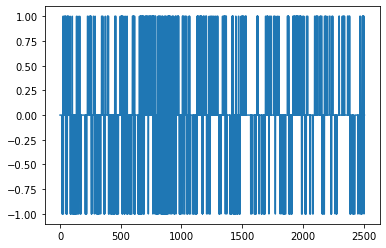

In [ ]:
plt.plot(Y[:,12])



---


На образце по 12-му инструменту часто пляшет изменение



---



In [ ]:
for n in range(Y.shape[1]):
    print(acc_list[n],np.unique(Y[:,n],return_counts=True))

TGKA.ME (array([-1.,  0.,  1.]), array([ 568, 1466,  473]))
FEES.ME (array([-1.,  0.,  1.]), array([ 178, 2136,  193]))
VTBR.ME (array([-1.,  0.,  1.]), array([ 458, 1641,  408]))
TGKB.ME (array([0.]), array([2507]))
HYDR.ME (array([-1.,  0.,  1.]), array([  89, 2359,   59]))
TGKD.ME (array([-1.,  0.,  1.]), array([ 118, 2336,   53]))
TGKN.ME (array([0.]), array([2507]))
RSTI.ME (array([-1.,  0.,  1.]), array([  90, 2330,   87]))
ENRU.ME (array([-1.,  0.,  1.]), array([  85, 2354,   68]))
SNGS.ME (array([-1.,  0.,  1.]), array([  55, 2414,   38]))
MRKV.ME (array([-1.,  0.,  1.]), array([ 441, 1660,  406]))
GAZP.ME (array([-1.,  0.,  1.]), array([  60, 2405,   42]))
MRKZ.ME (array([-1.,  0.,  1.]), array([ 393, 1704,  410]))
MRKP.ME (array([-1.,  0.,  1.]), array([ 182, 2087,  238]))
SNGSP.ME (array([-1.,  0.,  1.]), array([  68, 2401,   38]))
MAGN.ME (array([-1.,  0.,  1.]), array([  79, 2396,   32]))
TGKDP.ME (array([-1.,  0.]), array([   2, 2505]))
MSNG.ME (array([-1.,  0.,  1.]), ar

# Входы с задержкой

## Анализ входов

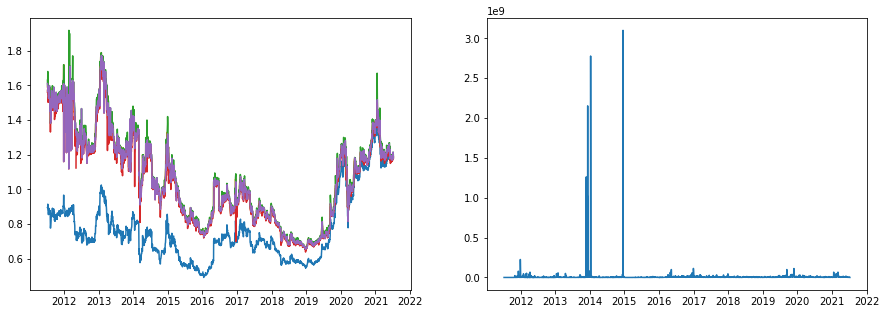

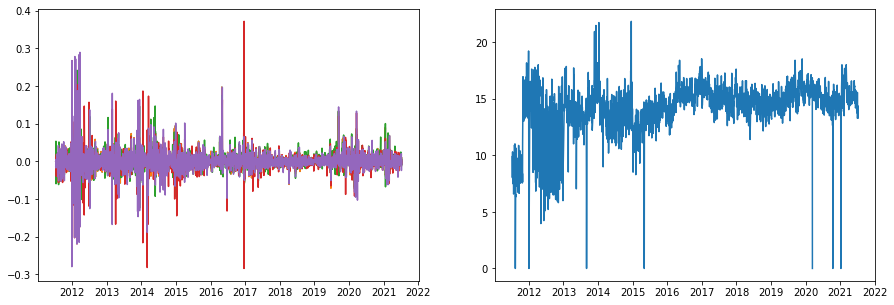

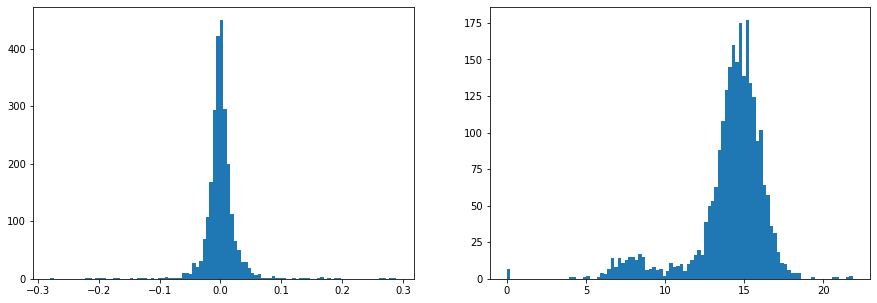

In [ ]:
sample_acc = np.random.choice(acc_list)
sample_data = all_data[[(gr,sample_acc) for gr in np.unique([gr for gr,acc in all_data.columns])]]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sample_data.iloc[:,:-1])
plt.subplot(1,2,2)
plt.plot(sample_data.iloc[:,-1])
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sample_data.iloc[:,:-1].pct_change())
plt.subplot(1,2,2)
plt.plot(sample_data.iloc[:,-1].apply(np.log1p))
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(sample_data.iloc[:,-2].pct_change(),bins=100)
plt.subplot(1,2,2)
plt.hist(sample_data.iloc[:,-1].apply(np.log1p),bins=100)
plt.show()

можно для котировок использовать изменение, а для объемов использовать логарифмическое преобразование

## Преобразование

In [ ]:
dData = all_data.copy()
aohlc = dData.iloc[:,:-int(len(dData.columns)/6)]
aohlc.iloc[:,:] = aohlc.pct_change()
v = dData.iloc[:,-int(len(dData.columns)/6):]
v.iloc[:,:] = v.apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [ ]:
dData.isna().sum().max()

290

максимальное число пустых элементов в столбце

не много

можно заполнить

## карты

In [ ]:
all_len,mapsCnt = dData.shape
zad = 40
X_maps = np.zeros((all_len,zad,mapsCnt))
for n in range(zad):
    X_maps[:,n,:] = dData.shift(n).values

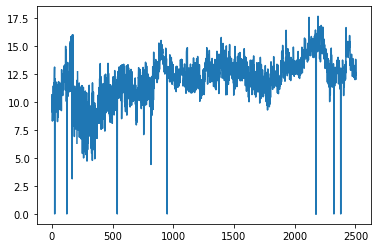

In [ ]:
plt.plot(X_maps[:,0,-4])

## Даты

In [ ]:
X_date = np.hstack([np.array([dData.index.day.values/31,dData.index.weekday.values/7,dData.index.month/12]).T])
X_date = np.hstack([np.sin(X_date),np.cos(X_date)])
X_date.shape

(2507, 6)

# Обучение и тест (делим выборки)

In [ ]:
X_maps_train, X_maps_test, X_date_train, X_date_test, Y_train, Y_test = sl_ms.train_test_split(X_maps,X_date,Y,test_size=0.2,shuffle=False)

for n in range(X_maps_train.shape[2]):
    mean = np.nanmean(X_maps_train[:,:,n])
    X_maps_train[:,:,n] -= mean
    X_maps_test[:,:,n] -= mean
    std = np.nanstd(X_maps_train[:,:,n])
    X_maps_train[:,:,n] /= std if std > 1e-5 else 1
    X_maps_test[:,:,n] /= std if std > 1e-5 else 1
    # break
    
X_maps_train[np.isnan(X_maps_train)] = 0

In [ ]:
X_maps_train.shape, X_maps_test.shape, X_date_train.shape, X_date_test.shape, Y_train.shape, Y_test.shape

((2005, 40, 318), (502, 40, 318), (2005, 6), (502, 6), (2005, 53), (502, 53))

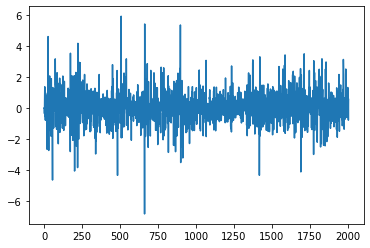

In [ ]:
plt.plot(X_maps_train[:,1,40])

# Учим - тестим

## Обучение

In [ ]:
def build_model(hp):
    inputMaps = keras.Input(X_maps_train[0].shape,name='inputMaps')
    inputDate = keras.Input(X_date_train[0].shape,name='inputDate')

    xMaps = keras.layers.Conv1D(filters=hp.Choice('filters1',range(10,200,10)),
                                kernel_size=hp.Choice('kernel1',[2,3,4,5]),
                                input_shape=X_maps_train[0].shape,
                                activation=tf.nn.sigmoid)(inputMaps)
    xMaps = keras.layers.MaxPool1D()(xMaps)
    xMaps = keras.layers.BatchNormalization()(xMaps)
    xMaps = keras.layers.Conv1D(filters=hp.Choice('filters2',range(10,200,10)),
                                kernel_size=hp.Choice('kernel2',[2,3,4,5]),
                                input_shape=X_maps_train[0].shape,
                                activation=tf.nn.sigmoid)(xMaps)
    xMaps = keras.layers.MaxPool1D()(xMaps)
    xMaps = keras.layers.Dropout(hp.Choice('dropout',list(np.logspace(-2,-0.5,10))))(xMaps)
    xMaps = keras.layers.Flatten()(xMaps)

    x = keras.layers.concatenate([xMaps,inputDate])

    x = keras.layers.Dense(hp.Choice('dense',range(10,200,10)),activation=tf.nn.sigmoid)(x)
    output = keras.layers.Dense(3,activation=tf.nn.softmax)(x)

    model = keras.Model(inputs={'inputMaps':inputMaps,'inputDate':inputDate},outputs=output)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp.Choice('learning_rate',list(np.logspace(-4,-2)))),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=20,
                        overwrite=True,
                        )

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train[:,0]+1),
                                                  Y_train[:,0]+1)

tuner.search(x={'inputMaps':X_maps_train,'inputDate':X_date_train},
             y=Y_train[:,0]+1,
             epochs=100,
             verbose=True,
             validation_split=0.3,
             callbacks=[keras.callbacks.EarlyStopping(patience=20,
                                                      restore_best_weights=True)],
             class_weight={k:v for k,v in zip(np.unique(Y_train[:,0]+1),class_weights)})

bhp = tuner.get_best_hyperparameters()[0]

print(bhp.values)

model = build_model(bhp)

model.fit(x={'inputMaps':X_maps_train,'inputDate':X_date_train},
          y=Y_train[:,0]+1,
          epochs=100,
          verbose=True,
          validation_split=0.3,
          callbacks=[keras.callbacks.EarlyStopping(patience=20,
                                                   restore_best_weights=True)],
          class_weight={k:v for k,v in zip(np.unique(Y_train[:,0]+1),class_weights)}
          )

Trial 20 Complete [00h 00m 13s]
val_loss: 1.101622223854065

Best val_loss So Far: 1.0534635782241821
Total elapsed time: 00h 04m 10s
INFO:tensorflow:Oracle triggered exit
{'filters1': 170, 'kernel1': 3, 'filters2': 150, 'kernel2': 4, 'dropout': 0.03162277660168379, 'dense': 160, 'learning_rate': 0.00017575106248547912}
Epoch 1/100
44/44 [==============================] - 1s 10ms/step - loss: 0.8012 - val_loss: 1.1910
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 0.7217 - val_loss: 1.1177
Epoch 3/100
44/44 [==============================] - 0s 7ms/step - loss: 0.6138 - val_loss: 1.1651
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 0.5806 - val_loss: 1.1513
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 0.5613 - val_loss: 1.1639
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.5505 - val_loss: 1.1405
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 0.5319 - v

## Тестирование

In [ ]:
Y_pred_train = np.argmax(model.predict({'inputMaps':X_maps_train,'inputDate':X_date_train}),axis=1)-1
Y_pred_test = np.argmax(model.predict({'inputMaps':X_maps_test,'inputDate':X_date_test}),axis=1)-1
print('------------ train -----------')
print(classification_report(Y_train[:,0],Y_pred_train))
print('------------ test -----------')
print(classification_report(Y_test[:,0],Y_pred_test))

------------ train -----------
              precision    recall  f1-score   support

        -1.0       0.59      0.68      0.63       399
         0.0       0.87      0.90      0.89      1360
         1.0       0.78      0.41      0.53       246

    accuracy                           0.80      2005
   macro avg       0.74      0.66      0.68      2005
weighted avg       0.80      0.80      0.79      2005

------------ test -----------
              precision    recall  f1-score   support

        -1.0       0.37      0.84      0.51       169
         0.0       0.26      0.27      0.26       106
         1.0       0.00      0.00      0.00       227

    accuracy                           0.34       502
   macro avg       0.21      0.37      0.26       502
weighted avg       0.18      0.34      0.23       502



## Схема сети

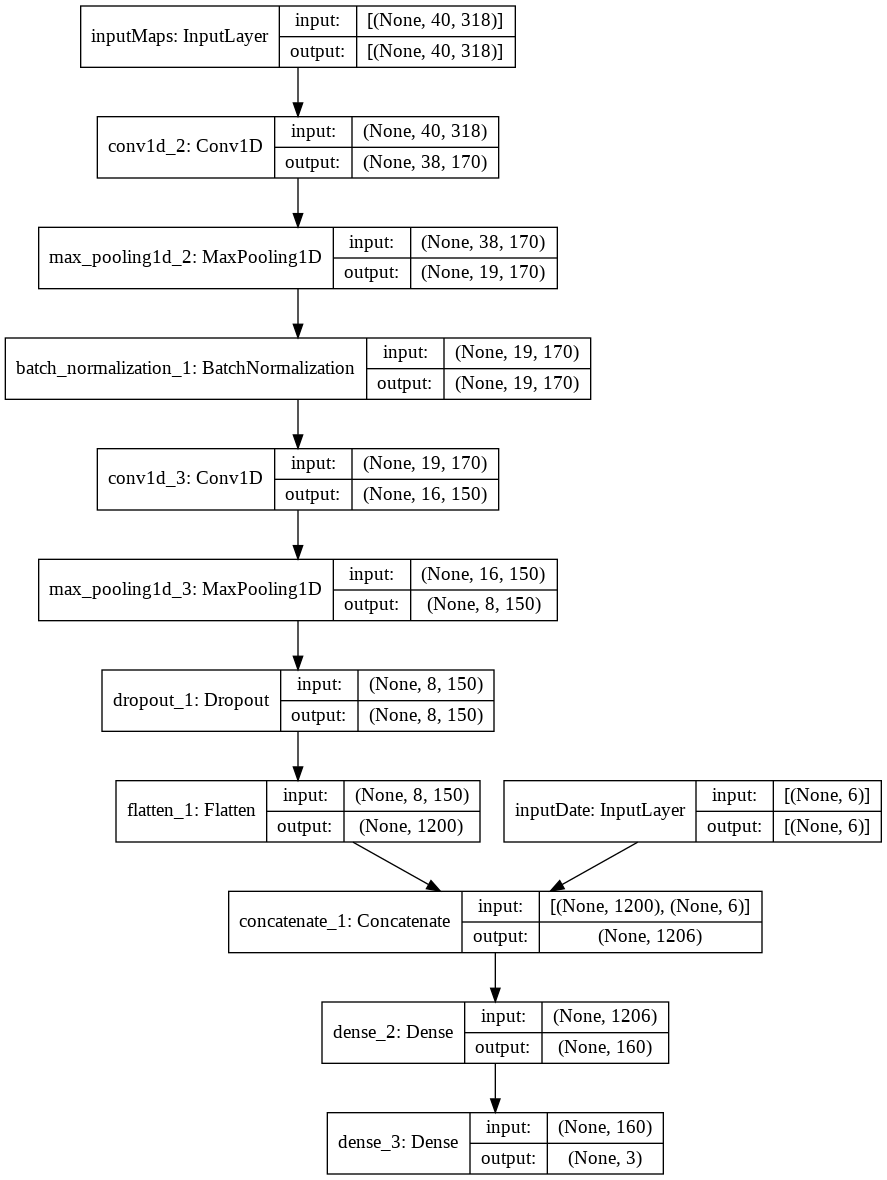

In [ ]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)